# Import Libraries & Dataset

In [19]:
# Import libraries | Standard
import pandas as pd
import numpy as np
import os
import datetime
import warnings
from time import time

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import utility as ut
import xgboost as xgb
from lightgbm import LGBMRegressor

# Pretty display for notebooks
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)  

pd.set_option('display.max_rows', None)

In [4]:
warnings.filterwarnings('ignore')

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

cnt = 0
env = 'Outside Kaggle'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cnt += 1
        print(os.path.join(dirname, filename))
        
if cnt > 0:
    env = 'Kaggle Kernel'

In [4]:
print('Environment:', env)

Environment: Outside Kaggle


In [5]:
# Read input files
if env == 'Kaggle':
    features = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv")
    stores = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
    train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv")
    test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv")
else:    
    features = pd.read_csv("data/features.csv")
    stores = pd.read_csv("data/stores.csv")
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")

In [6]:
train=ut.reduce_mem_usage(train)
test=ut.reduce_mem_usage(test)

Memory usage of dataframe is 13.27 MB
Memory usage after optimization is: 6.03 MB
Decreased by 54.5%
Memory usage of dataframe is 2.74 MB
Memory usage after optimization is: 1.21 MB
Decreased by 56.0%


# Exploratory Data Analysis

### 1. Stores Data

In [16]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [18]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [19]:
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


###### Takeaway: This dataset seems to be supplimentary (metadata) and is clean. Column TYPE is a candidate for one-hot encoding. 

### 2. Features Data

In [20]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [21]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


In [22]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [23]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [24]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

<BarContainer object of 12 artists>

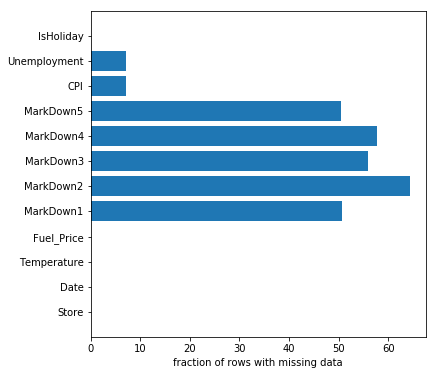

In [25]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

In [26]:
features['Date'].str.slice(start=0, stop=4).value_counts()

2012    2340
2011    2340
2010    2160
2013    1350
Name: Date, dtype: int64

In [27]:
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

In [28]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [29]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

###### Takeaway: This dataset is supplimentary and requires pre-processing. 
1. Column(s) ISHOLIDAY has been validated
2. Column(s) UNEMPLOYMENT, CPI & MARKDOWN* have NULL values and would need to be pre-processed

### 3. Train Data

In [31]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.500000,False
1,1,1,2010-02-12,46039.488281,True
2,1,1,2010-02-19,41595.550781,False
3,1,1,2010-02-26,19403.539062,False
4,1,1,2010-03-05,21827.900391,False


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int8
Dept            421570 non-null int8
Date            421570 non-null object
Weekly_Sales    421570 non-null float32
IsHoliday       421570 non-null bool
dtypes: bool(1), float32(1), int8(2), object(1)
memory usage: 6.0+ MB


In [33]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15978.299805
std,12.785297,30.492054,22707.693359
min,1.000000,1.000000,-4988.939941
25%,11.000000,18.000000,2079.649902
50%,22.000000,37.000000,7612.029785
75%,33.000000,74.000000,20205.852051
max,45.000000,99.000000,693099.375000


In [34]:
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

In [35]:
# Validate Holidays
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [36]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

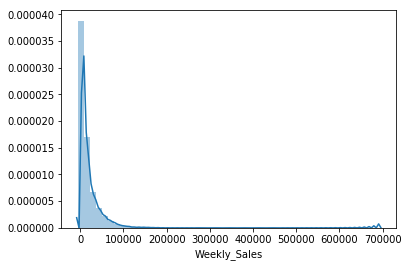

In [37]:
#histogram
sns.distplot(train['Weekly_Sales'])

In [38]:
train['Store'][train['Weekly_Sales'] < 0].sum()

30658

###### Takeaway: Training dataset is clean. However, column DATE is non-numeric and is a candidate for pre-processing.

### 4. Test Data

In [39]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int8
Dept         115064 non-null int8
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int8(2), object(1)
memory usage: 1.2+ MB


In [41]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [42]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [43]:
# Validate Holidays
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [44]:
test['Date'][test['IsHoliday'].isin([1])][~test['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

###### Takeaway: Test dataset is clean. However, column DATE is non-numeric and is a candidate for pre-processing.

# Data Pre-Processing

## 1. Fill NaN Values

### Features dataset has NaN values for multiple columns:

##### Columns: CPI and Unemployment

In [45]:
features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts()

2013-05    225
2013-06    180
2013-07    180
Name: Date, dtype: int64

In [46]:
features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts()

2013-05    225
2013-06    180
2013-07    180
Name: Date, dtype: int64

In [47]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
...                   ...           ...
2     2011-02  212.727665         8.028
      2011-03  213.877488         8.028
      2011-04  214.908582         7.931
      2011-05  215.398826         7.931
      2011-06  214.754360         7.931
      2011-07  214.998246         7.852
      2011-08  215.291750         7.852
      2011-09  215.810080         7.852
      2011-10  217.047711         7.441
      2011-11  217.777737         7.441
      2011-12  218.792544         7.441
      2012-01  219.558147         7.057
      2012-02  220.014484         7.057
      2012-03  220.791516         7.057
      2012-04  221.170021         6.891
      2012-05  221.358968         6.891
      2012-06  221.419302         6.891
      2012-07  221.557961         6.565
      2012-08  221.721490         6.565
      2012-09  222.331393         6.565
      2012-10  222.992375         6.170
      2012-11  223.159882         6.170
      2012-12  223.427985         6.170
      2013-01  223.821473         6.237
      2013-02  223.925989         6.237
      2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

NOTE: Columns CPI and UNEMPLOYMENT are missing values for 3 months May, Jun & Jul 2013. Values from Apr 2019 would be propogated to records with missing values. 

In [48]:
%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


##### Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5

In [49]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


NOTE: Columns MARKDOWN* are missing values for the whole of 2010 and 2011 (upto Nov). 2012 values would be copied over to records with missing values. Also, to facilitate the copy, new columns WEEK and YEAR would be derived from DATE.

In [50]:
%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3.93 s, sys: 0 ns, total: 3.93 s
Wall time: 3.93 s


In [51]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [52]:
features.to_csv('features_new.csv', index=False)

In [53]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [54]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
Week            8190 non-null int64
Year            8190 non-null object
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


In [55]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]        

CPU times: user 1min 6s, sys: 165 ms, total: 1min 7s
Wall time: 1min 7s


In [56]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [57]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

## 2. Merge Datasets

### Merge the following datasets:
1. Stores + Features + Train
2. Stores + Features + Test

In [58]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

In [59]:
test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [60]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [61]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [62]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [63]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

## 3. Feature Engineering

#### Column #1: IsHoliday
Column has boolean values and would ned converted to numeric. 

In [64]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

#### Column #2: Type
Column is categorical and would be converted to numeric via one-hot encoding. 

In [65]:
train['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [66]:
test['Type'].value_counts()

A    58713
B    44500
C    11851
Name: Type, dtype: int64

In [67]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

#### Column #3: Week
New numeric column being created to replace YEAR. 

In [68]:
train['Week'] = test['Week'] = 0

In [69]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3min 51s, sys: 7.17 ms, total: 3min 51s
Wall time: 3min 51s


In [70]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 1min, sys: 3.97 ms, total: 1min
Wall time: 1min 1s


In [71]:
# Create checkpoint
train.to_csv('train_prescaled.csv', index=False)
test.to_csv('test_prescaled.csv', index=False)

In [34]:
# Restore checkpoint
train = pd.read_csv("train_prescaled.csv")
test = pd.read_csv("test_prescaled.csv")

In [35]:
# Create Submission dataframe
submission = test[['Store', 'Dept', 'Date']].copy()
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

### Scale Datasets

In [73]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 
             'CPI', 'Unemployment', 'Week', 'Type_A', 'Type_B', 'Type_C',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train_scaled = pd.DataFrame(data = train)
train_scaled[numerical] = scaler.fit_transform(train[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,0.0,0.0,2010-02-05,24924.50,0.0,0.630267,0.434149,0.050100,0.395322,0.036694,0.001268,0.480236,0.007346,0.840500,0.405118,0.078431,1.0,0.0,0.0
1,0.0,0.0,2010-02-12,46039.49,1.0,0.630267,0.396967,0.038076,0.164364,0.068645,0.000874,0.125556,0.008974,0.841941,0.405118,0.098039,1.0,0.0,0.0
2,0.0,0.0,2010-02-19,41595.55,0.0,0.630267,0.410861,0.021042,0.119052,0.108107,0.000260,0.124629,0.004459,0.842405,0.405118,0.117647,1.0,0.0,0.0
3,0.0,0.0,2010-02-26,19403.54,0.0,0.630267,0.476419,0.044589,0.113195,0.074646,0.000216,0.018080,0.010604,0.842707,0.405118,0.137255,1.0,0.0,0.0
4,0.0,0.0,2010-03-05,21827.90,0.0,0.630267,0.475147,0.076653,0.181322,0.017510,0.000267,0.376301,0.010505,0.843008,0.405118,0.156863,1.0,0.0,0.0


In [74]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.fit_transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

,Store,Dept,Date,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,0.0,0.0,2012-11-02,0.0,0.630267,0.573142,0.410215,0.090103,0.072893,0.001537,0.055703,0.003788,0.943588,0.443438,0.843137,1.0,0.0,0.0
1,0.0,0.0,2012-11-09,0.0,0.630267,0.627334,0.352753,0.134031,0.047907,0.001467,0.071112,0.008215,0.943778,0.443438,0.862745,1.0,0.0,0.0
2,0.0,0.0,2012-11-16,0.0,0.630267,0.551172,0.303272,0.117752,0.004610,0.001891,0.017341,0.008810,0.944101,0.443438,0.882353,1.0,0.0,0.0
3,0.0,0.0,2012-11-23,1.0,0.630267,0.581472,0.270551,0.034587,0.000561,0.501726,0.003212,0.000633,0.944603,0.443438,0.901961,1.0,0.0,0.0
4,0.0,0.0,2012-11-30,0.0,0.630267,0.545862,0.267358,0.049464,0.000503,0.026844,0.002304,0.009268,0.945105,0.443438,0.921569,1.0,0.0,0.0


In [75]:
# Free up memory
train = test = features = stores = None

In [76]:
# Create checkpoint
train_scaled.to_csv('train_scaled.csv', index=False)
test_scaled.to_csv('test_scaled.csv', index=False)

In [7]:
# Restore checkpoint
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

In [8]:
# Drop non-numeric columns
train_scaled.drop(columns=['Date'], axis=1, inplace=True)
test_scaled.drop(columns=['Date'], axis=1, inplace=True)

### Analyze Feature Correlation

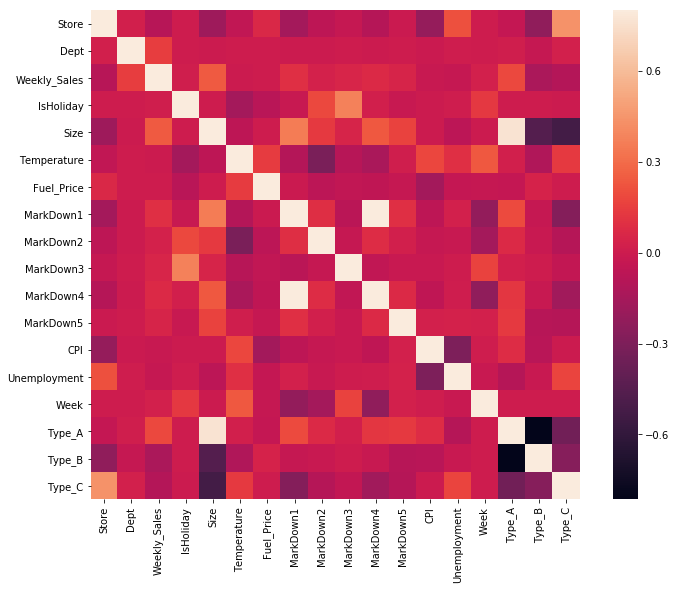

In [14]:
#correlation matrix
corrmat = train_scaled.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

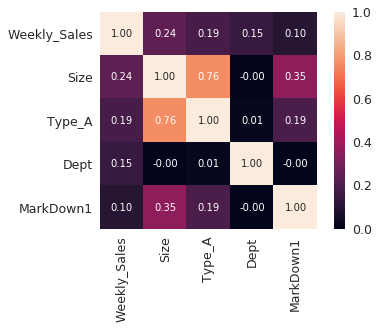

In [15]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Weekly_Sales')['Weekly_Sales'].index
cm = np.corrcoef(train_scaled[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

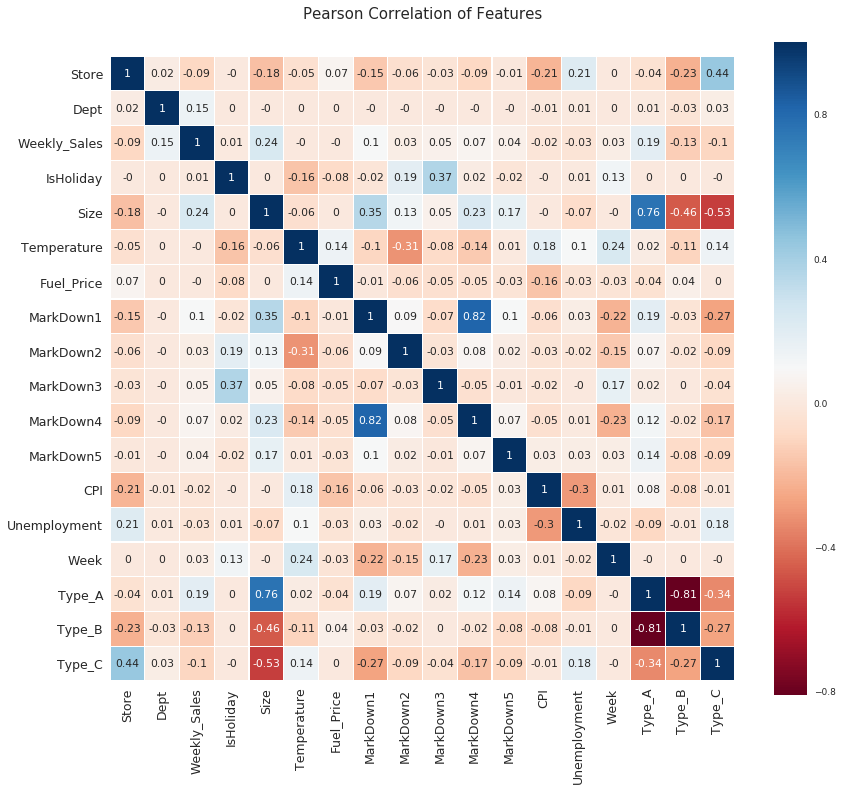

In [16]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(train_scaled.astype(float).corr(),2),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

###### Takeaway: 
1. SIZE is corelated with TYPE columns. These would be removed. 
2. WEEKLY_SALES is not related with TEMPERATURE, FUEL_PRICE and MARKDOWN1. These would be removed. 

train_scaled.drop(columns=['Type_A', 'Type_B', 'Type_C', 'MarkDown1', 'Temperature', 'Fuel_Price'], axis=1, inplace=True)
test_scaled.drop(columns=['Type_A', 'Type_B', 'Type_C', 'MarkDown1', 'Temperature', 'Fuel_Price'], axis=1, inplace=True)

train_scaled.drop(columns=['Temperature', 'Fuel_Price'], axis=1, inplace=True)
test_scaled.drop(columns=['Temperature', 'Fuel_Price'], axis=1, inplace=True)

In [9]:
train_scaled.drop(columns=['Type_A', 'Type_B', 'Type_C', 'MarkDown1' ], axis=1, inplace=True)
test_scaled.drop(columns=['Type_A', 'Type_B', 'Type_C', 'MarkDown1'], axis=1, inplace=True)

In [10]:
weekly_sales = train_scaled['Weekly_Sales']
train_scaled = train_scaled.drop('Weekly_Sales', axis = 1)

In [11]:
(weekly_sales < 0).value_counts()

False    420285
True       1285
Name: Weekly_Sales, dtype: int64

weekly_sales = weekly_sales.apply(lambda x: 0 if x < 0 else x)

train_scaled['MarkDown2'] = train_scaled['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown3'] = train_scaled['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown4'] = train_scaled['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown5'] = train_scaled['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

test_scaled['MarkDown2'] = test_scaled['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown3'] = test_scaled['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown4'] = test_scaled['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown5'] = test_scaled['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

### Split Training dataset into Train & Validation

In [12]:
train_X, val_X, train_y, val_y = train_test_split(train_scaled, weekly_sales, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [13]:
# Validate shape
train_X.shape,val_X.shape, test_scaled.shape

((337256, 13), (84314, 13), (115064, 13))

In [14]:
# Free up memory
train_scaled = weekly_sales = None

In [15]:
# Reduce memory usage
train_X=ut.reduce_mem_usage(train_X)
val_X=ut.reduce_mem_usage(val_X)
test_scaled=ut.reduce_mem_usage(test_scaled)

Memory usage of dataframe is 36.02 MB
Memory usage after optimization is: 10.94 MB
Decreased by 69.6%
Memory usage of dataframe is 9.01 MB
Memory usage after optimization is: 2.73 MB
Decreased by 69.6%
Memory usage of dataframe is 11.41 MB
Memory usage after optimization is: 2.85 MB
Decreased by 75.0%


## 4. Modelling

### Select and evaluate candidate models

In [16]:
%%time
# Initialize the base models
model_A = Lasso(random_state=1)
model_B = ElasticNet(random_state=1)
model_C = RandomForestRegressor(random_state=1)
model_D = GradientBoostingRegressor(random_state=1)
model_E = xgb.XGBRegressor()
model_F = LGBMRegressor(random_state=1)

samples_100 = len(train_y)              # 100% of training set
samples_10 = int(samples_100 * 10/100)  #  10% of training set
samples_1 = int(samples_100 * 1/100)    #   1% of training set

# Collect results on the learners
results = {}
for model in [model_A, model_B, model_C, model_D, model_E, model_F]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[model_name][i] = \
        ut.train_predict(model, samples, train_X, train_y, val_X, val_y)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Lasso trained on 3372 samples.
Lasso trained on 33725 samples.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Lasso trained on 337256 samples.
ElasticNet trained on 3372 samples.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


ElasticNet trained on 33725 samples.
ElasticNet trained on 337256 samples.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor trained on 3372 samples.
RandomForestRegressor trained on 33725 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 3372 samples.
GradientBoostingRegressor trained on 33725 samples.
GradientBoostingRegressor trained on 337256 samples.
[17:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor trained on 3372 samples.
[17:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor trained on 33725 samples.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 3372 samples.
LGBMRegressor trained on 33725 samples.
LGBMRegressor trained on 337256 samples.
CPU times: user 1min 41s, sys: 329 ms, total: 1min 42s
Wall time: 1min 43s


NameError: name 'mpatches' is not defined

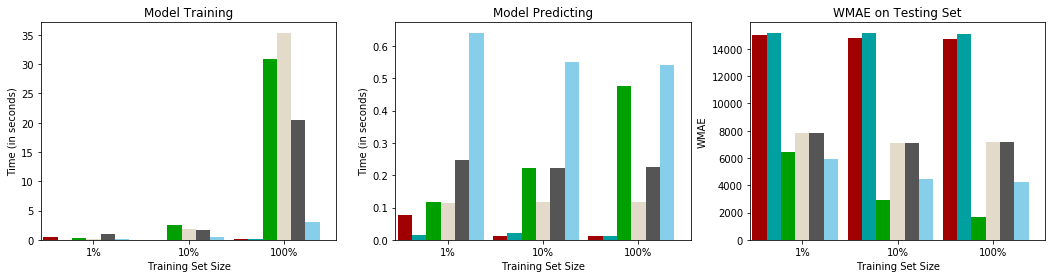

In [26]:
# Evaluate Metrics
ut.evaluate(results)

###### Takeaway: Random Forest and LGBM have turned out to be the top performing base models and would be further tunined and evaluated .

### Evaluate Random Forest (Ensemble)

In [22]:
%%time
model = RandomForestRegressor(random_state=42, n_estimators=100)

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 71.8 µs


In [23]:
%%time
model.fit(train_X, train_y)

CPU times: user 4min 13s, sys: 1.04 s, total: 4min 14s
Wall time: 4min 14s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [24]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = ut.weighted_mean_absolute_error(pred_y, val_y, ut.compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  3447.7653852932717
Mean Absolute Error: 1420.5677668643405
Weighted Mean Absolute Error:  1585.9265142648853


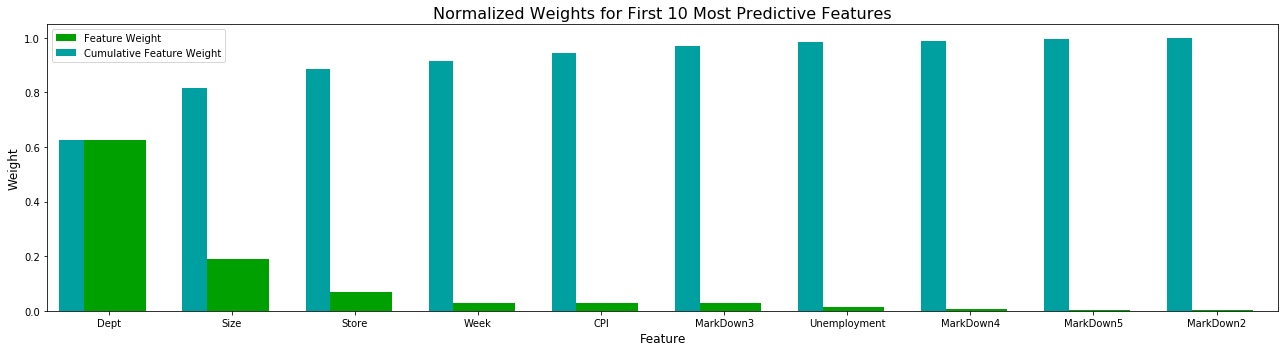

In [25]:
#Extract the feature importances
importances = model.feature_importances_

# Plot
ut.feature_plot(importances, train_X, train_y, 10)

In [22]:
topk = len(train_X.columns)
indices = np.argsort(importances)[::-1]
columns = train_X.columns.values[indices[:topk]]
values = importances[indices][:topk]

for i in range(topk):
    print(columns[i] + '\t: ' + str(values[i]))

Dept	: 0.6265256052479387
Size	: 0.18684065143982795
Store	: 0.05912657262256588
Week	: 0.029413125520785025
CPI	: 0.02707404392359961
MarkDown3	: 0.026588777851837653
Unemployment	: 0.011702945563817686
Type_B	: 0.010481570451825614
MarkDown4	: 0.005189522050089883
MarkDown2	: 0.004226122067946711
MarkDown5	: 0.0041463020118597356
MarkDown1	: 0.004063855837052695
Type_A	: 0.0033252296716043935
IsHoliday	: 0.0009122412300742451
Type_C	: 0.0003834345091740752


In [ ]:
pred_y_rf = model.predict(val_X)

In [26]:
pred_y_rf = model.predict(test_scaled)

In [27]:
param_grid = { 
    'n_estimators': [100, 500, 1000],
    #'criterion:': ['mse'],     
    'max_depth': [1, 3, 5],
    #min_samples_split=2,
    'max_features': ['auto', 'sqrt', 'log2'],
    #'bootstrap': [True, False],
    #'max_leaf_nodes':None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,       
    #min_samples_leaf=1, 
    #min_weight_fraction_leaf=0.0, 
    'oob_score': [True, False], 
    'random_state': [42], 
    'verbose': [1], 
    'warm_start': [False]    
}

In [ ]:
%%time
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
CV.fit(train_X, train_y)

In [95]:
CV.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

In [ ]:
%%time
model.fit(train_X, train_y)

In [ ]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = ut.weighted_mean_absolute_error(pred_y, val_y, ut.compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

### Evaluate LGBM (Boosting)

In [27]:
# Default model
model = LGBMRegressor()

In [45]:
param_grid = {
    'boosting_type': ['gbdt'], # for better accuracy -> try dart
    'objective': ['regression'],
    'random_state': [0],
    'learning_rate': [0.3],
    'n_estimators': [3000, 4000],
    'num_leaves': [60, 70, 80], # large num_leaves helps improve accuracy but might lead to over-fitting
    #'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    #'colsample_bytree': [0.5, 1],
    #'subsample': [0.5, 1],
    'reg_alpha': [0.05, 0.1],
    'reg_lambda': [1.5, 2],
    'min_child_samples': [5, 10]
}

In [ ]:
#CV_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid_lgbm, cv=3, verbose=1, scoring='neg_mean_absolute_error')
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
CV.fit(train_X, train_y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [49]:
print("Best parameter (CV score=%0.3f):" % CV.best_score_)
print(CV.best_params_)

Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 5, 'n_estimators': 4000, 'num_leaves': 80, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 2}


Best parameter (CV score=0.956):
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 30, 'objective': 'regression', 'random_state': 0}

Best parameter (CV score=0.976):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 1000, 'num_leaves': 40, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.5}

Best parameter (CV score=0.978):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 2000, 'num_leaves': 50, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1}
     
Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 3000, 'num_leaves': 60, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1.5}

Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 5, 'n_estimators': 4000, 'num_leaves': 80, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 2}

In [59]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=4000, n_jobs=-1, num_leaves=80, objective='regression',
       random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [22]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=60, objective='regression',
       random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [23]:
%%time
model.fit(train_X, train_y)

CPU times: user 45.7 s, sys: 24 ms, total: 45.7 s
Wall time: 45.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=60, objective='regression',
       random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [24]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = ut.weighted_mean_absolute_error(pred_y, val_y, ut.compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  2705.0672693274287
Mean Absolute Error: 1394.0527342476
Weighted Mean Absolute Error:  1474.991509066066


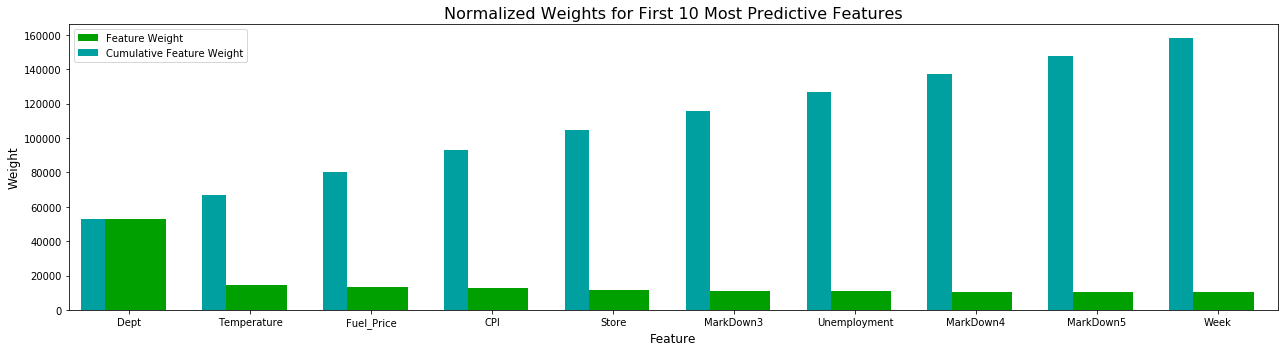

In [25]:
#Extract the feature importances
importances = model.feature_importances_

# Plot
ut.feature_plot(importances, train_X, train_y, 10)

In [ ]:
pred_y_lgbm = model.predict(val_X)

In [31]:
pred_y_lgbm = model.predict(test_scaled)

In [41]:
pred_y = model.predict(test_scaled)

## Model Stacking

In [32]:
# Blend the results of the two regressors and save the prediction to a CSV file.

#pred_y = (pred_y_rf + pred_y_lgbm) / 2
pred_y = (pred_y_rf * 0.7) + (pred_y_lgbm * 0.3)
#pred_y = np.exp(pred_y)

In [79]:
# make predictions
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = ut.weighted_mean_absolute_error(pred_y, val_y, ut.compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

ValueError: Found input variables with inconsistent numbers of samples: [84314, 115064]

In [40]:
submission['Weekly_Sales'] = pred_y_rf # Random Forest

In [76]:
submission['Weekly_Sales'] = pred_y_lgbm # LGBM

In [36]:
submission['Weekly_Sales'] = pred_y # Blended

In [37]:
submission[['Id','Weekly_Sales']].to_csv('submission.csv', index=False)

In [15]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_X', 9738291),
 ('train_y', 4721608),
 ('val_X', 4173567),
 ('test_scaled', 2876704),
 ('val_y', 2023560),
 ('BaggingRegressor', 1056),
 ('DecisionTreeRegressor', 1056),
 ('GradientBoostingRegressor', 1056),
 ('GridSearchCV', 1056),
 ('KFold', 1056),
 ('LGBMRegressor', 1056),
 ('MinMaxScaler', 1056),
 ('RandomForestRegressor', 1056),
 ('compute_weights', 136),
 ('cross_val_score', 136),
 ('evaluate', 136),
 ('feature_plot', 136),
 ('mean_absolute_error', 136),
 ('mean_squared_error', 136),
 ('mean_squared_log_error', 136),
 ('reduce_mem_usage', 136),
 ('train_predict', 136),
 ('train_test_split', 136),
 ('weighted_mean_absolute_error', 136),
 ('mpatches', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('xgb', 80),
 ('train_scaled', 16),
 ('weekly_sales', 16)]